In [4]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0


In [5]:
!mkdir -p GTSRB
!unzip -q gtsrb-german-traffic-sign.zip -d GTSRB

# German Traffic Sign Recognition with Convolutional Neural Networks

## 1. Pendahuluan

### 1.1. Permasalahan
Pengenalan rambu lalu lintas secara otomatis merupakan komponen penting dalam sistem transportasi cerdas dan kendaraan otonom. Sistem ini harus mampu mengidentifikasi dan mengklasifikasikan berbagai jenis rambu lalu lintas dengan akurasi tinggi dalam berbagai kondisi. Tantangan dalam domain ini mencakup variasi pencahayaan, sudut pandang, kondisi cuaca, dan kerusakan pada rambu yang dapat memengaruhi akurasi pengenalan.

### 1.2. Tujuan Notebook
Notebook ini bertujuan untuk membangun, melatih, dan mengevaluasi model Convolutional Neural Network (CNN) untuk klasifikasi rambu lalu lintas Jerman menggunakan dataset GTSRB (German Traffic Sign Recognition Benchmark). Secara spesifik, tujuan dari notebook ini adalah:

1. Menganalisis dan memahami dataset GTSRB
2. Membangun model CNN dengan arsitektur Sequential, Conv2D, dan Pooling Layer
3. Mencapai akurasi minimal 95% pada data training dan testing
4. Membuat visualisasi performa model melalui plot akurasi dan loss
5. Menyimpan model dalam format SavedModel, TF-Lite, dan TFJS untuk deployment di berbagai platform

### 1.3. Deskripsi Dataset
Dataset GTSRB (German Traffic Sign Recognition Benchmark) terdiri dari lebih dari 50.000 gambar yang mewakili 43 kelas rambu lalu lintas Jerman yang berbeda. Dataset ini menyediakan gambar dengan berbagai resolusi, kondisi pencahayaan, dan sudut pengambilan yang berbeda, menjadikannya tantangan realistis untuk klasifikasi gambar.

Atribut penting dalam dataset ini meliputi:
- Width: Lebar gambar
- Height: Tinggi gambar
- Roi.X1, Roi.Y1: Koordinat pojok kiri atas rambu pada gambar
- Roi.X2, Roi.Y2: Koordinat pojok kanan bawah rambu pada gambar
- ClassId: Kelas dari gambar yang disediakan
- Path: Jalur ke gambar yang disediakan

Dataset ini dibagi menjadi folder Train dan Test, dengan file CSV pendamping yang berisi metadata untuk setiap gambar.

## 2. Import Library dan Setup Lingkungan

Pada bagian ini, kita akan mengimpor semua library yang diperlukan untuk memproses data, membangun model, dan mengevaluasi hasil.

In [6]:
# Import library standar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image
import random
from tqdm import tqdm
import cv2

# Import library TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Import library untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Verifikasi versi TensorFlow
print("TensorFlow version:", tf.__version__)

# Mengatur seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Mengaktifkan GPU jika tersedia
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and enabled')
else:
    print('No GPU found, using CPU instead')

TensorFlow version: 2.18.0
GPU is available and enabled


## 3. Persiapan dan Eksplorasi Data

Pada bagian ini, kita akan memuat dataset, melakukan eksplorasi data, dan mempersiapkannya untuk digunakan dalam pelatihan model.

### 3.1. Memuat Dataset

In [7]:
# Mendefinisikan path untuk dataset
base_path = 'GTSRB'  # Sesuaikan dengan lokasi dataset Anda
train_path = os.path.join(base_path, 'Train')
test_path = os.path.join(base_path, 'Test')
train_csv_path = os.path.join(base_path, 'Train.csv')
test_csv_path = os.path.join(base_path, 'Test.csv')

# Memuat CSV data
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

# Tampilkan informasi dataset
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:")
print(train_data.columns)
print("\nSample of train data:")
print(train_data.head())

# Periksa jumlah kelas unik
num_classes = len(train_data['ClassId'].unique())
print(f"\nTotal jumlah kelas: {num_classes}")

Train data shape: (39209, 8)
Test data shape: (12630, 8)

Train data columns:
Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

Sample of train data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Total jumlah kelas: 43


### 3.2. Eksplorasi Dataset

#### 3.2.1. Distribusi Kelas

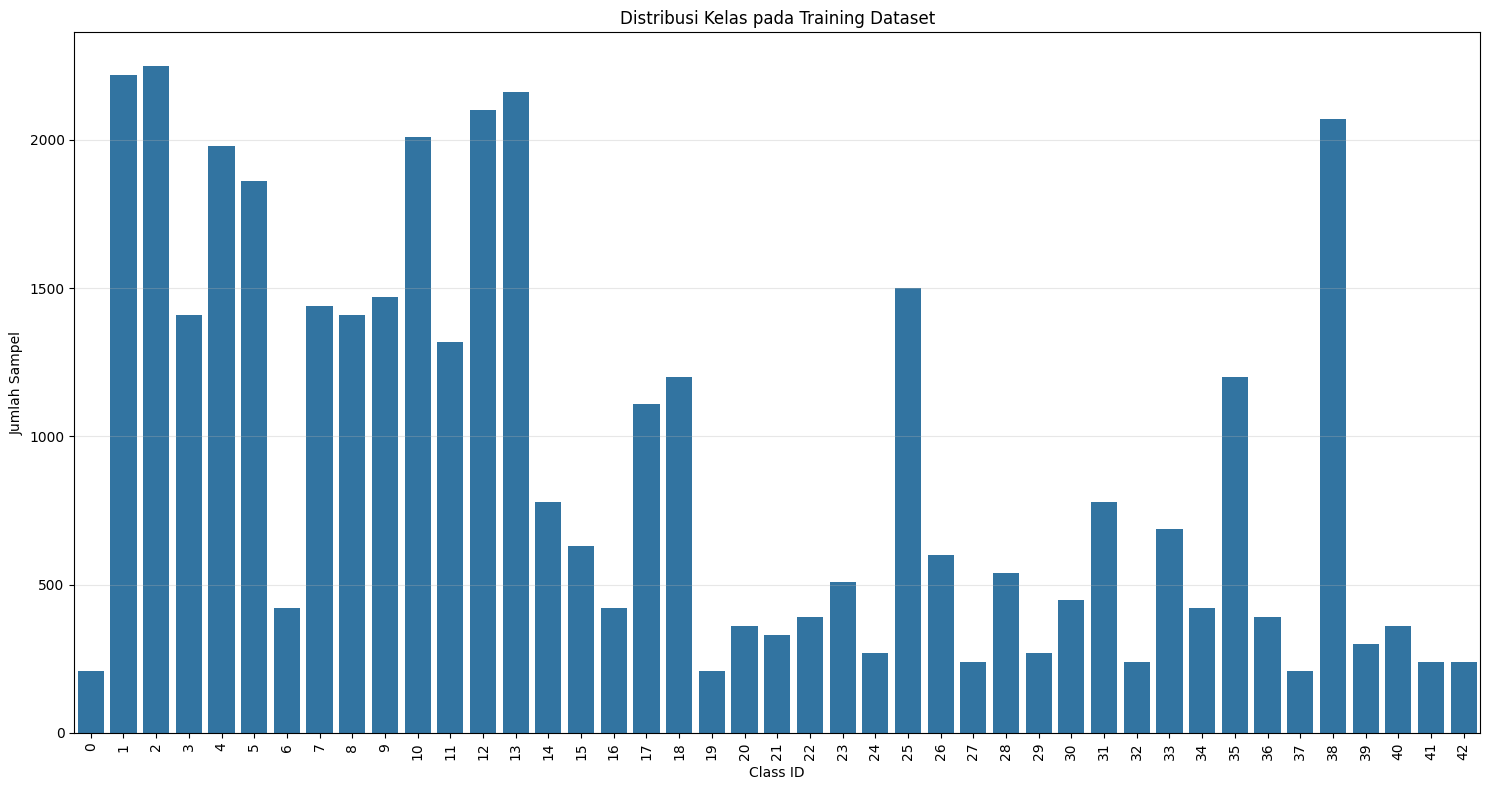

Distribusi kelas:
Class 0: 210 samples
Class 1: 2220 samples
Class 2: 2250 samples
Class 3: 1410 samples
Class 4: 1980 samples
Class 5: 1860 samples
Class 6: 420 samples
Class 7: 1440 samples
Class 8: 1410 samples
Class 9: 1470 samples
Class 10: 2010 samples
Class 11: 1320 samples
Class 12: 2100 samples
Class 13: 2160 samples
Class 14: 780 samples
Class 15: 630 samples
Class 16: 420 samples
Class 17: 1110 samples
Class 18: 1200 samples
Class 19: 210 samples
Class 20: 360 samples
Class 21: 330 samples
Class 22: 390 samples
Class 23: 510 samples
Class 24: 270 samples
Class 25: 1500 samples
Class 26: 600 samples
Class 27: 240 samples
Class 28: 540 samples
Class 29: 270 samples
Class 30: 450 samples
Class 31: 780 samples
Class 32: 240 samples
Class 33: 689 samples
Class 34: 420 samples
Class 35: 1200 samples
Class 36: 390 samples
Class 37: 210 samples
Class 38: 2070 samples
Class 39: 300 samples
Class 40: 360 samples
Class 41: 240 samples
Class 42: 240 samples


In [8]:
# Visualisasi distribusi kelas
plt.figure(figsize=(15, 8))
sns.countplot(data=train_data, x='ClassId')
plt.title('Distribusi Kelas pada Training Dataset')
plt.xlabel('Class ID')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Hitung distribusi kelas
class_distribution = train_data['ClassId'].value_counts().sort_index()
print("Distribusi kelas:")
for class_id, count in class_distribution.items():
    print(f"Class {class_id}: {count} samples")

#### 3.2.2. Eksplorasi Ukuran Gambar

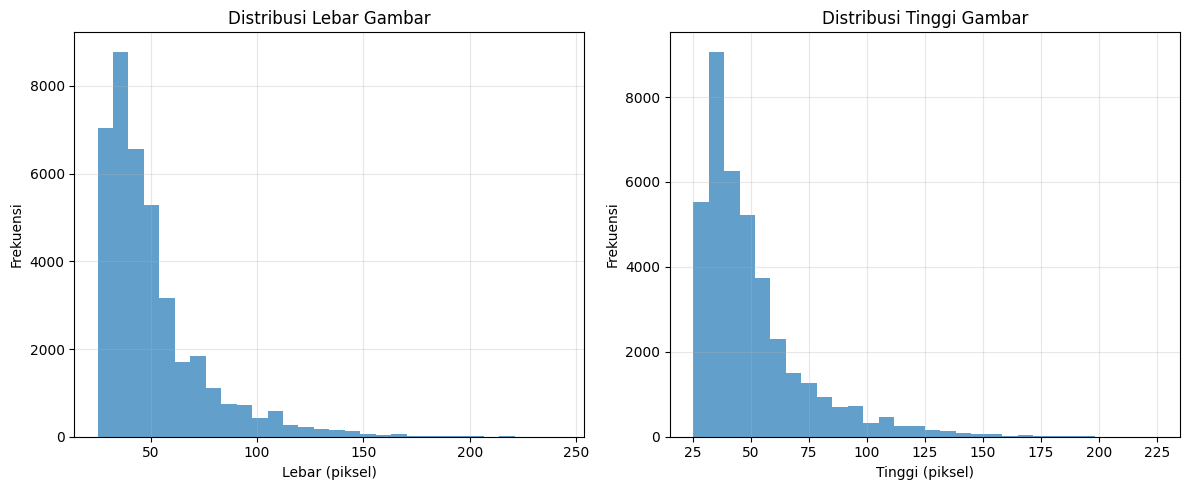

Statistik Lebar Gambar:
count    39209.000000
mean        50.835880
std         24.306933
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        243.000000
Name: Width, dtype: float64

Statistik Tinggi Gambar:
count    39209.000000
mean        50.328930
std         23.115423
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        225.000000
Name: Height, dtype: float64


In [9]:
# Analisis ukuran gambar
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['Width'], bins=30, alpha=0.7)
plt.title('Distribusi Lebar Gambar')
plt.xlabel('Lebar (piksel)')
plt.ylabel('Frekuensi')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_data['Height'], bins=30, alpha=0.7)
plt.title('Distribusi Tinggi Gambar')
plt.xlabel('Tinggi (piksel)')
plt.ylabel('Frekuensi')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis statistik ukuran gambar
print("Statistik Lebar Gambar:")
print(train_data['Width'].describe())
print("\nStatistik Tinggi Gambar:")
print(train_data['Height'].describe())

#### 3.2.3. Visualisasi Sampel Gambar

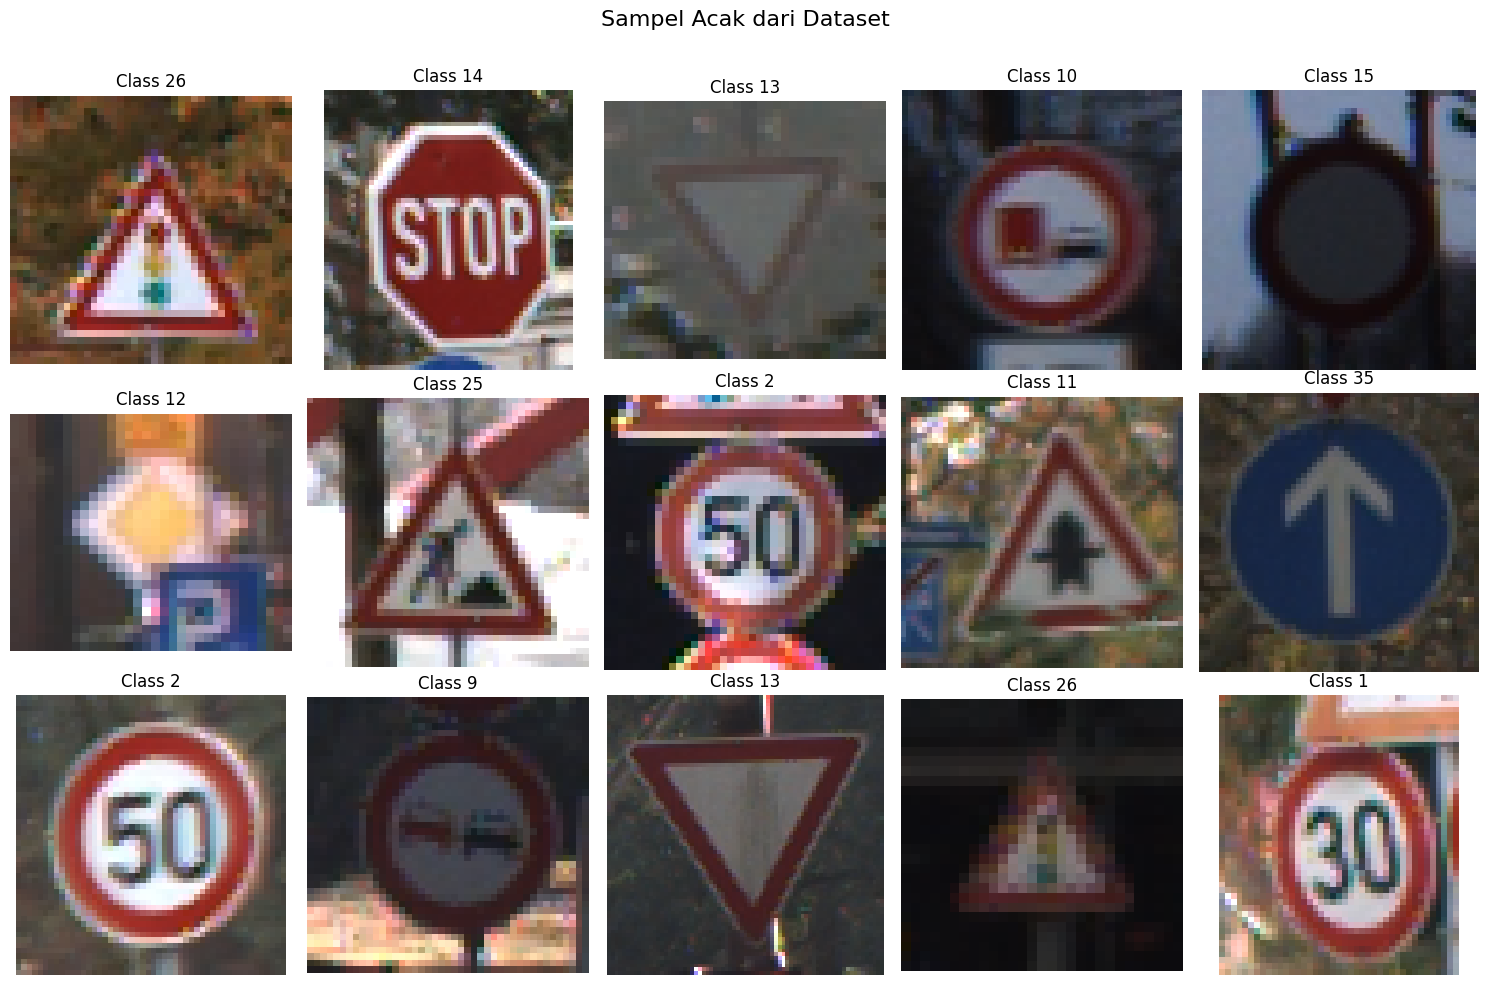

In [10]:
# Fungsi untuk menampilkan beberapa sampel gambar dari dataset
def show_random_samples(data, base_path, n_samples=15):
    plt.figure(figsize=(15, 10))

    # Pilih sampel acak
    samples = data.sample(n_samples, random_state=SEED)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(base_path, row['Path'])
        img = plt.imread(img_path)

        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f"Class {row['ClassId']}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Sampel Acak dari Dataset', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Tampilkan sampel gambar dari training dataset
show_random_samples(train_data, base_path)

## 4. Pra-pemrosesan Data

Pada bagian ini, kita akan melakukan pra-pemrosesan data untuk mempersiapkan gambar sebelum digunakan untuk melatih model.

### 4.1. Standarisasi Ukuran Gambar

In [11]:
# Definisikan ukuran target untuk semua gambar
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS = 3  # RGB

# Fungsi untuk memuat dan pra-pemrosesan gambar
def load_and_preprocess_images(data, base_path):
    images = []
    labels = []

    for idx, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Images"):
        img_path = os.path.join(base_path, row['Path'])
        try:
            # Baca gambar
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB

            # Resize gambar ke ukuran standar
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

            # Normalisasi piksel ke rentang [0, 1]
            img = img / 255.0

            images.append(img)
            labels.append(row['ClassId'])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)

# Memuat dan pra-pemroses data training
X_train, y_train = load_and_preprocess_images(train_data, base_path)

# Memuat dan pra-pemroses data testing
X_test, y_test = load_and_preprocess_images(test_data, base_path)

# Konversi label ke format one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train_onehot.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test_onehot.shape)

Processing Images: 100%|██████████| 12630/12630 [00:03<00:00, 3777.54it/s]


Training data shape: (39209, 32, 32, 3)
Training labels shape: (39209, 43)
Testing data shape: (12630, 32, 32, 3)
Testing labels shape: (12630, 43)


### 4.2. Pemisahan Data untuk Validasi

In [12]:
# Memisahkan sebagian data training untuk validasi
X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(
    X_train, y_train_onehot,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train
)

print("Final Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Final Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


### 4.3. Augmentasi Data

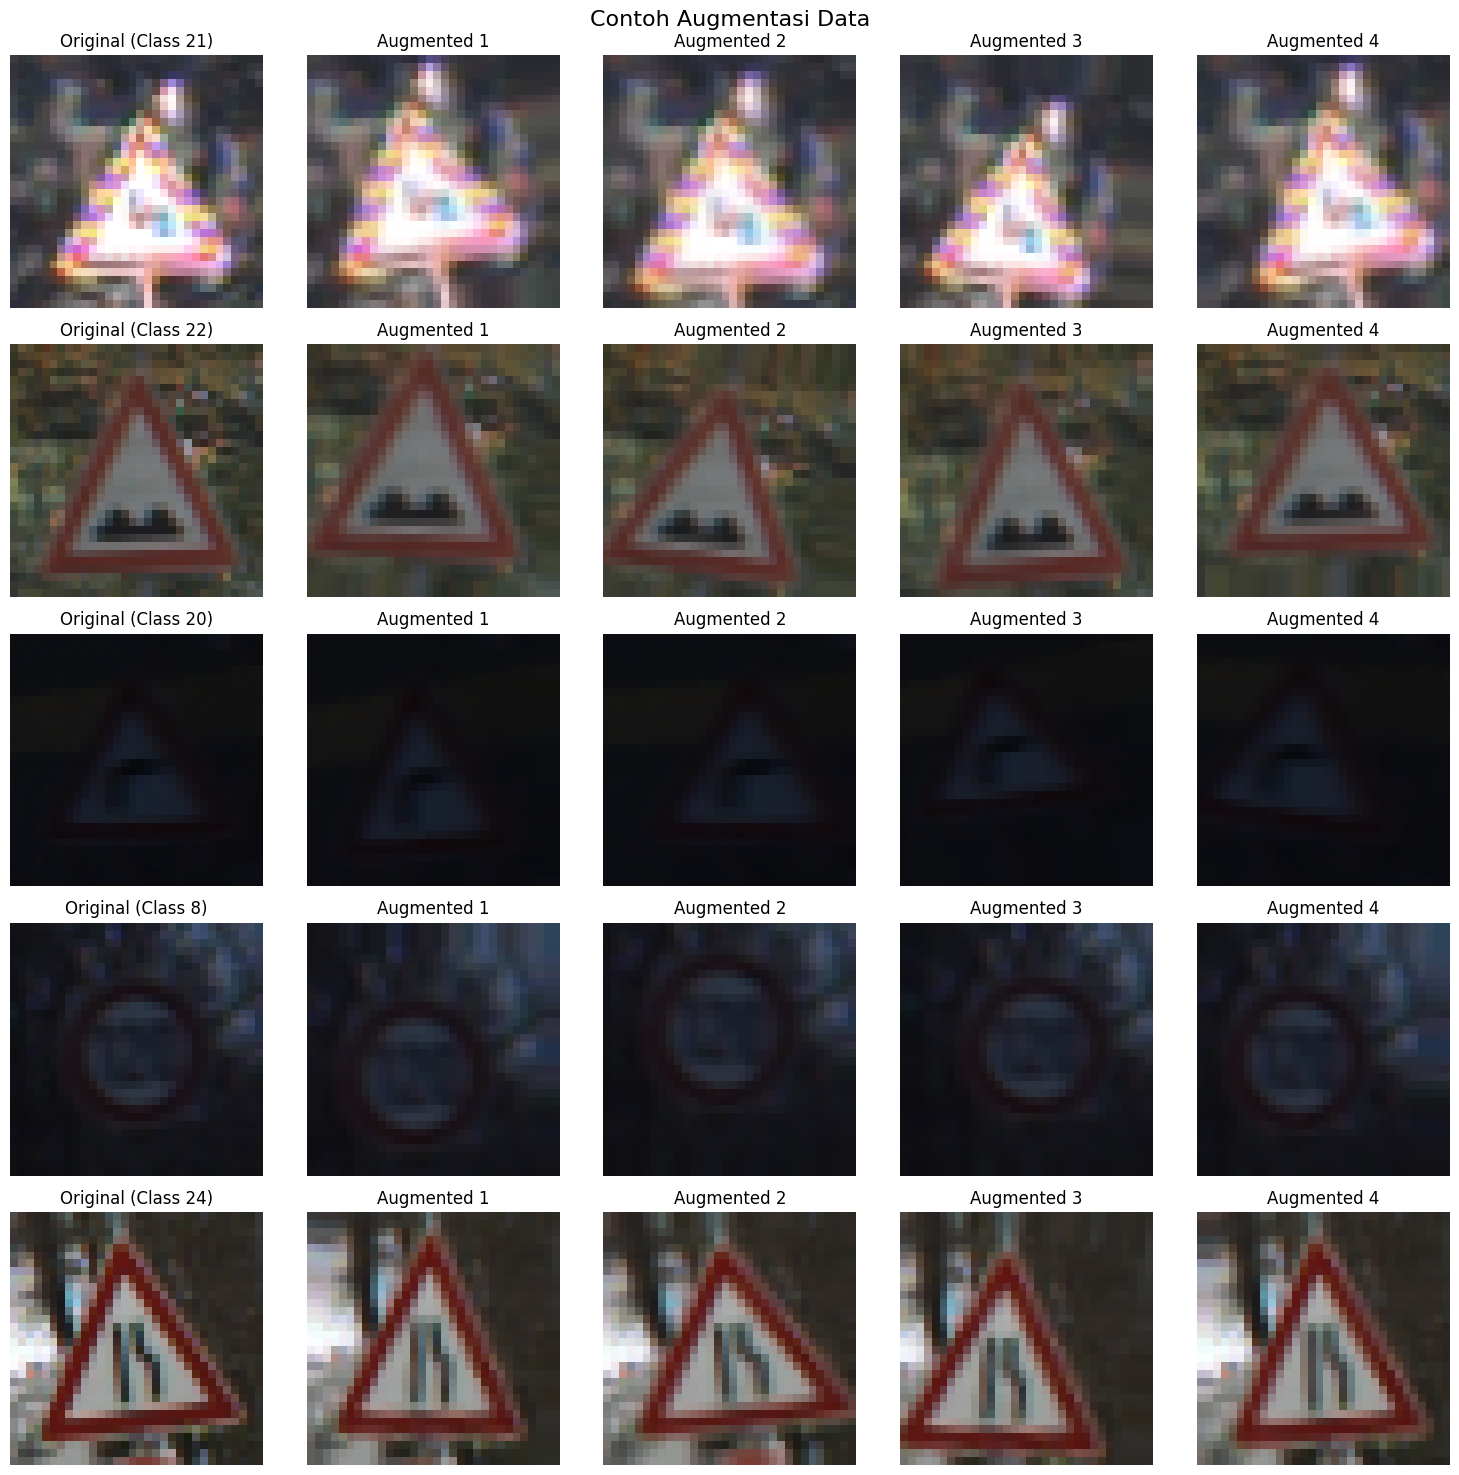

In [13]:
# Augmentasi data untuk meningkatkan variasi dataset training
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,  # Tidak flip horizontal untuk rambu lalu lintas
    vertical_flip=False,    # Tidak flip vertikal untuk rambu lalu lintas
    fill_mode='nearest'
)

# Visualisasi contoh augmentasi data
def show_augmented_images(X_sample, y_sample, n_samples=5):
    fig, axes = plt.subplots(n_samples, 5, figsize=(15, n_samples*3))

    for i in range(n_samples):
        original_img = X_sample[i]
        label = np.argmax(y_sample[i])

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Class {label})")
        axes[i, 0].axis('off')

        # Generate 4 augmented versions of the same image
        aug_iter = data_augmentation.flow(np.expand_dims(original_img, 0), batch_size=1)

        for j in range(4):
            # Using next(iterator) instead of iterator.next()
            aug_img = next(aug_iter)[0]
            axes[i, j+1].imshow(aug_img)
            axes[i, j+1].set_title(f"Augmented {j+1}")
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.suptitle('Contoh Augmentasi Data', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Ambil beberapa sampel untuk visualisasi
indices = np.random.choice(len(X_train), 5, replace=False)
X_sample = X_train[indices]
y_sample = y_train_onehot[indices]

# Tampilkan contoh augmentasi
show_augmented_images(X_sample, y_sample)

## 5. Membangun Model CNN

Pada bagian ini, kita akan membangun model CNN dengan arsitektur Sequential, menggunakan layer Conv2D dan Pooling sesuai dengan kriteria.

In [14]:
# Membangun model CNN dengan Sequential API
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Flatten and Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Inisialisasi model
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
model = build_cnn_model(input_shape, num_classes)

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,361,995 (5.20 MB)

 Trainable params: 1,360,075 (5.19 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 6. Implementasi Callbacks

In [15]:
# Definisikan callbacks untuk optimasi proses training
callbacks = [
    # Menyimpan model terbaik berdasarkan validasi accuracy
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Early stopping untuk menghentikan training jika tidak ada peningkatan
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        verbose=1,
        restore_best_weights=True
    ),

    # Mengurangi learning rate jika performa stagnant
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),

    # TensorBoard untuk visualisasi real-time
    TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        write_graph=True
    )
]

# Class implementasi Custom Callback untuk tracking history
class TrainingMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Print status setiap epoch
        print(f"\nEpoch {epoch+1} completed")
        print(f"Training accuracy: {logs['accuracy']:.4f}, Loss: {logs['loss']:.4f}")
        print(f"Validation accuracy: {logs['val_accuracy']:.4f}, Loss: {logs['val_loss']:.4f}")

        # Check apakah sudah mencapai target akurasi 95%
        if logs['accuracy'] >= 0.95 and logs['val_accuracy'] >= 0.95:
            print("\nTarget akurasi 95% telah tercapai pada training dan validation data!")

# Tambahkan custom callback
callbacks.append(TrainingMonitor())

## 7. Melatih Model

In [16]:
# Parameter training
BATCH_SIZE = 64
EPOCHS = 30

# Training model dengan data augmentation
history = model.fit(
    data_augmentation.flow(X_train, y_train_onehot, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_onehot),
    callbacks=callbacks,
    verbose=1
)

# Load model terbaik (jika menggunakan ModelCheckpoint)
model.load_weights('best_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2852 - loss: 3.0033
Epoch 1: val_accuracy improved from -inf to 0.72201, saving model to best_model.h5



Epoch 1 completed
Training accuracy: 0.4793, Loss: 1.9302
Validation accuracy: 0.7220, Loss: 0.8821
490/490 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.2856 - loss: 3.0011 - val_accuracy: 0.7220 - val_loss: 0.8821 - learning_rate: 0.0010
Epoch 2/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8281 - loss: 0.4895

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.72201 to 0.72890, saving model to best_model.h5



Epoch 2 completed
Training accuracy: 0.8281, Loss: 0.4895
Validation accuracy: 0.7289, Loss: 0.8621
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8281 - loss: 0.4895 - val_accuracy: 0.7289 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 3/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8190 - loss: 0.5552
Epoch 3: val_accuracy improved from 0.72890 to 0.97883, saving model to best_model.h5



Epoch 3 completed
Training accuracy: 0.8599, Loss: 0.4343
Validation accuracy: 0.9788, Loss: 0.0729
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8192 - loss: 0.5547 - val_accuracy: 0.9788 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 4/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8594 - loss: 0.4355
Epoch 4: val_accuracy improved from 0.97883 to 0.98023, saving model to best_model.h5



Epoch 4 completed
Training accuracy: 0.8594, Loss: 0.4355
Validation accuracy: 0.9802, Loss: 0.0709
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4355 - val_accuracy: 0.9802 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 5/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9262 - loss: 0.2332
Epoch 5: val_accuracy improved from 0.98023 to 0.99069, saving model to best_model.h5



Epoch 5 completed
Training accuracy: 0.9328, Loss: 0.2139
Validation accuracy: 0.9907, Loss: 0.0320
490/490 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9262 - loss: 0.2332 - val_accuracy: 0.9907 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 6/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9531 - loss: 0.1224
Epoch 6: val_accuracy did not improve from 0.99069

Epoch 6 completed
Training accuracy: 0.9531, Loss: 0.1224
Validation accuracy: 0.9902, Loss: 0.0329

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1224 - val_accuracy: 0.9902 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 7/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9530 - loss: 0.1464
Epoch 7: val_accuracy improved from 0.99069 to 0.99350, saving model to best_model.h5



Epoch 7 completed
Training accuracy: 0.9568, Loss: 0.1348
Validation accuracy: 0.9935, Loss: 0.0194

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9530 - loss: 0.1463 - val_accuracy: 0.9935 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 8/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9531 - loss: 0.0749
Epoch 8: val_accuracy did not improve from 0.99350

Epoch 8 completed
Training accuracy: 0.9531, Loss: 0.0749
Validation accuracy: 0.9935, Loss: 0.0186

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9531 - loss: 0.0749 - val_accuracy: 0.9935 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 9/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9692 - loss: 0.0993
Epoch 9: val_accuracy improved from 0.99350 to 0.99503, saving model to best_model.h5



Epoch 9 completed
Training accuracy: 0.9702, Loss: 0.0945
Validation accuracy: 0.9950, Loss: 0.0147

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9692 - loss: 0.0993 - val_accuracy: 0.9950 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 10/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9531 - loss: 0.1041
Epoch 10: val_accuracy improved from 0.99503 to 0.99515, saving model to best_model.h5



Epoch 10 completed
Training accuracy: 0.9531, Loss: 0.1041
Validation accuracy: 0.9952, Loss: 0.0144

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1041 - val_accuracy: 0.9952 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 11/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9738 - loss: 0.0841
Epoch 11: val_accuracy improved from 0.99515 to 0.99707, saving model to best_model.h5



Epoch 11 completed
Training accuracy: 0.9722, Loss: 0.0853
Validation accuracy: 0.9971, Loss: 0.0106

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9738 - loss: 0.0841 - val_accuracy: 0.9971 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 12/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9688 - loss: 0.1064
Epoch 12: val_accuracy did not improve from 0.99707

Epoch 12 completed
Training accuracy: 0.9688, Loss: 0.1064
Validation accuracy: 0.9969, Loss: 0.0106

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1064 - val_accuracy: 0.9969 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 13/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9764 - loss: 0.0758
Epoch 13: val_accuracy did not improve from 0.99707

Epoch 13 completed
Training accuracy: 0.9760, Loss: 0.0789
Validation accuracy: 0.9968, Los


Epoch 17 completed
Training accuracy: 0.9818, Loss: 0.0575
Validation accuracy: 0.9991, Loss: 0.0035

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9809 - loss: 0.0600 - val_accuracy: 0.9991 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 18/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 1.0000 - loss: 0.0198
Epoch 18: val_accuracy did not improve from 0.99911

Epoch 18 completed
Training accuracy: 1.0000, Loss: 0.0198
Validation accuracy: 0.9990, Loss: 0.0035

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 0.9990 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 19/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9828 - loss: 0.0575
Epoch 19: val_accuracy did not improve from 0.99911

Epoch 19 completed
Training accuracy: 0.9821, Loss: 0.0586
Validation accuracy: 0.9983, Los


Epoch 23 completed
Training accuracy: 0.9925, Loss: 0.0240
Validation accuracy: 0.9992, Loss: 0.0024

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9906 - loss: 0.0306 - val_accuracy: 0.9992 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 24/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 24: val_accuracy did not improve from 0.99923

Epoch 24 completed
Training accuracy: 1.0000, Loss: 0.0014
Validation accuracy: 0.9992, Loss: 0.0024

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 25/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9945 - loss: 0.0184
Epoch 25: val_accuracy improved from 0.99923 to 0.99962, saving model to best_model.h5



Epoch 25 completed
Training accuracy: 0.9942, Loss: 0.0183
Validation accuracy: 0.9996, Loss: 0.0017

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9945 - loss: 0.0184 - val_accuracy: 0.9996 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 26/30
  1/490 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 26: val_accuracy did not improve from 0.99962

Epoch 26 completed
Training accuracy: 1.0000, Loss: 0.0049
Validation accuracy: 0.9996, Loss: 0.0017

Target akurasi 95% telah tercapai pada training dan validation data!
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9996 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 27/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9948 - loss: 0.0164
Epoch 27: val_accuracy did not improve from 0.99962

Epoch 27 completed
Training accuracy: 0.9951, Loss: 0.0150
Validation accuracy: 0.9

## 8. Evaluasi Model

Pada bagian ini, kita akan mengevaluasi performa model pada data training dan testing.

### 8.1. Plot Akurasi dan Loss


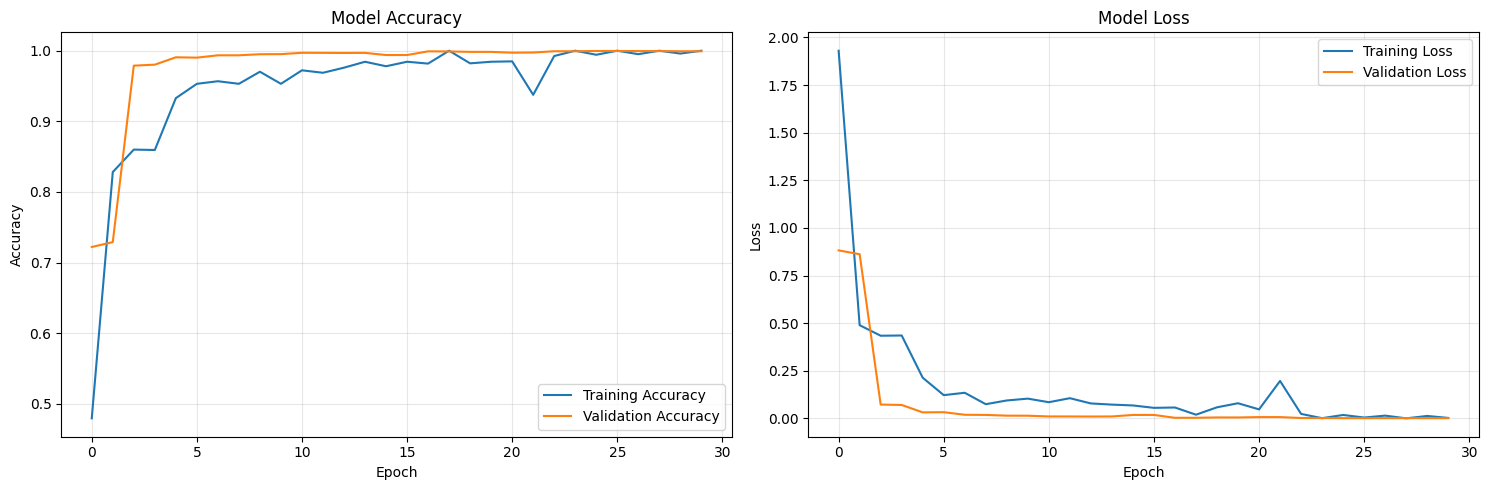

In [17]:
# Plot history pelatihan
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot history
plot_history(history)

### 8.2. Evaluasi pada Data Testing

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9862 - loss: 0.0597
Test Accuracy: 0.9850
Test Loss: 0.0646
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


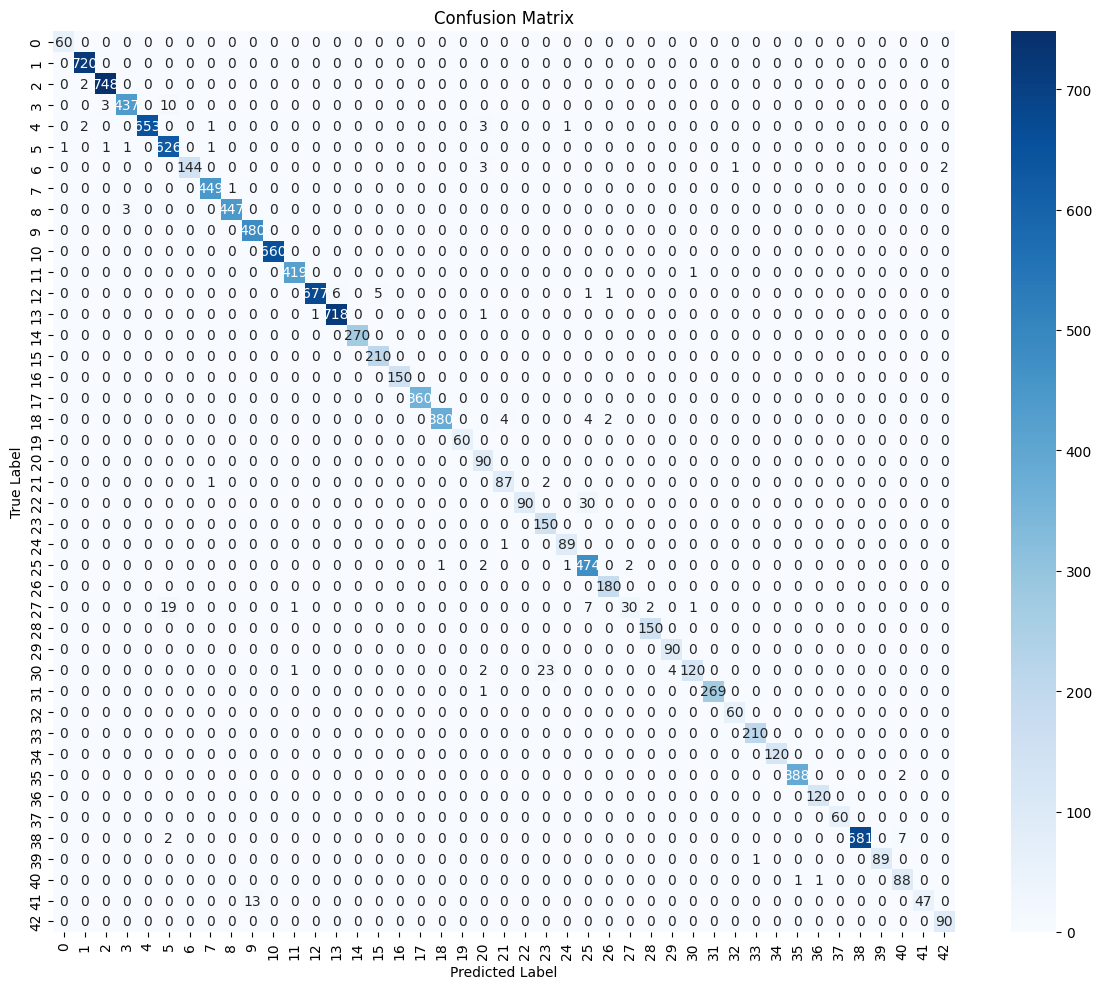

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      1.00       750
           3       0.99      0.97      0.98       450
           4       1.00      0.99      0.99       660
           5       0.95      0.99      0.97       630
           6       1.00      0.96      0.98       150
           7       0.99      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       0.97      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00       150
    

In [18]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Prediksi pada test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

### 8.3. Visualisasi Prediksi

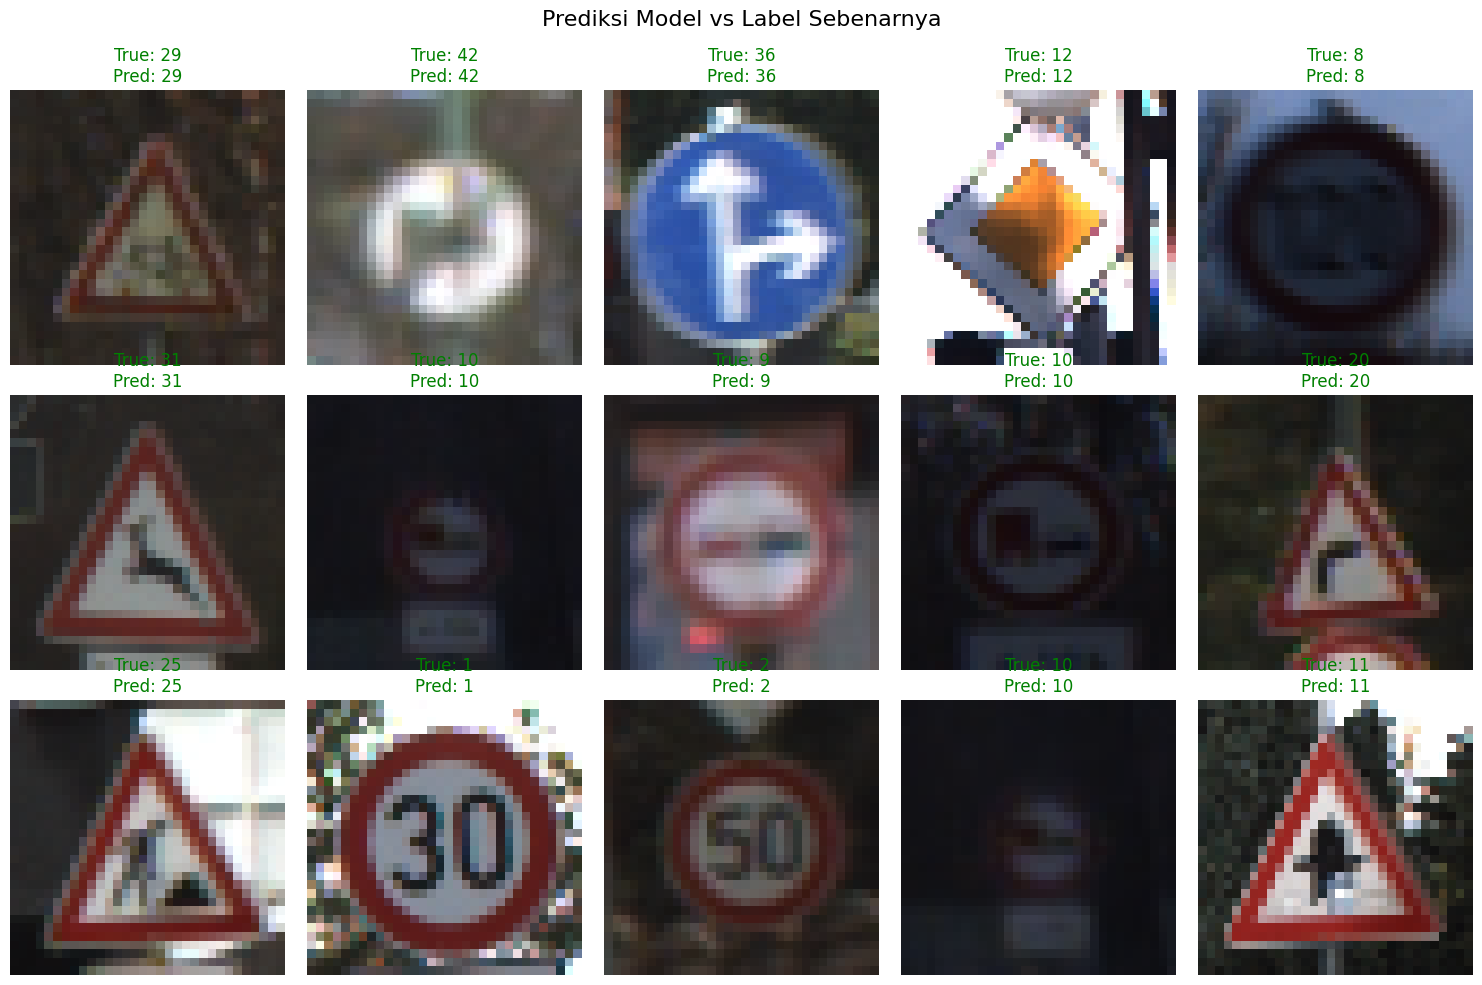

In [19]:
# Visualisasi beberapa sampel dan hasil prediksi
def visualize_predictions(X, y_true, y_pred, n_samples=15):
    # Pilih sampel acak
    indices = np.random.choice(len(X), n_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i+1)
        plt.imshow(X[idx])

        true_class = np.argmax(y_true[idx])
        pred_class = np.argmax(y_pred[idx])

        title_color = 'green' if true_class == pred_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Prediksi Model vs Label Sebenarnya', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualisasi prediksi
visualize_predictions(X_test, y_test_onehot, y_pred)

## 9. Menyimpan Model

Pada bagian ini, kita akan menyimpan model dalam tiga format berbeda: SavedModel, TF-Lite, dan TFJS.

### 9.1. Menyimpan dalam Format SavedModel

In [20]:
# Menyimpan model dalam format SavedModel
saved_model_path = './saved_model'

# Untuk TensorFlow 2.13+
try:
    # Mencoba menggunakan export method yang tersedia di TF 2.13+
    model.export(saved_model_path)
    print(f"Model exported to {saved_model_path} using model.export()")
except AttributeError:
    # Fallback jika menggunakan versi TF yang lebih lama
    try:
        tf.saved_model.save(model, saved_model_path)
        print(f"Model saved to {saved_model_path} using tf.saved_model.save()")
    except Exception as e:
        print(f"Error saving model: {e}")
        # Alternatif terakhir - simpan dalam format HDF5/Keras
        model.save('model.h5')
        print("Model saved in .h5 format as fallback")

# Menyimpan juga dalam format .keras untuk kompatibilitas
keras_model_path = './model.keras'
model.save(keras_model_path)
print(f"Model saved in Keras format to {keras_model_path}")

Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  138700136467152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383550096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383548560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136467536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136466576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383547984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383552976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383552016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383548176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383550480: T

### 9.2. Konversi dan Simpan dalam Format TF-Lite

In [21]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TF-Lite
tflite_path = './tflite'
os.makedirs(tflite_path, exist_ok=True)
with open(os.path.join(tflite_path, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

# Buat file label.txt
class_indices = list(range(num_classes))
with open(os.path.join(tflite_path, 'label.txt'), 'w') as f:
    for class_idx in class_indices:
        f.write(f"{class_idx}\n")

print(f"TF-Lite model saved to {tflite_path}")

Saved artifact at '/tmp/tmp83opxn57'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  138700136467152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383550096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383548560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136467536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700136466576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383547984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383552976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383552016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383548176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138695383550480

### 9.3. Konversi dan Simpan dalam Format TFJS

In [30]:
!pip install tensorflowjs

In [34]:
# Create TFJS model
tfjs_path = './tfjs_model'
os.makedirs(tfjs_path, exist_ok=True)

# Load model and save as H5 (intermediate step)
model = tf.keras.models.load_model('model.keras')
h5_path = 'model_for_tfjs.h5'
model.save(h5_path, save_format='h5')

# Convert H5 to TFJS format
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model {h5_path} {tfjs_path}

print(f"TensorFlow.js model saved to {tfjs_path}")

2025-04-24 11:36:55.382899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745494615.402313    6183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745494615.408262    6183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved to ./tfjs_model


## 10. Melakukan Inferensi dengan Model yang Telah Disimpan

Pada bagian ini, kita akan melakukan inferensi menggunakan model yang telah disimpan untuk memastikan model dapat berfungsi dengan baik dalam format yang berbeda.

### 10.1. Inferensi Menggunakan Model Keras

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model berhasil dimuat dari format .keras
SavedModel dimuat sebagai TFSMLayer
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


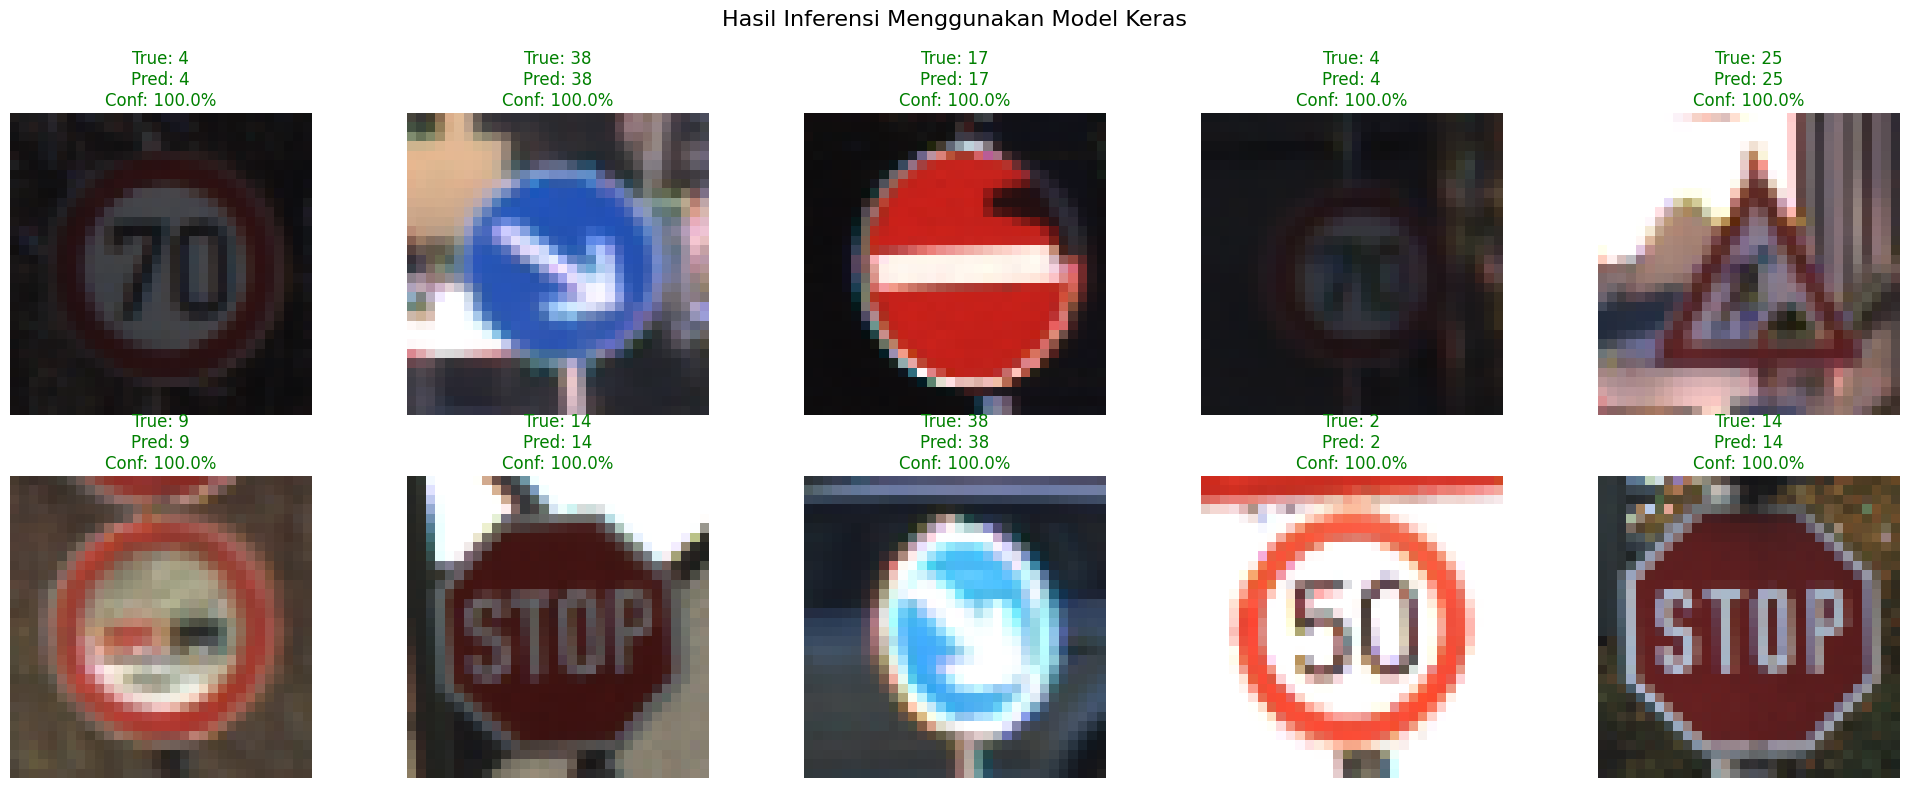

Akurasi pada 10 sampel test: 1.0000


In [24]:
# Memuat model dari format .keras
loaded_model = tf.keras.models.load_model('model.keras')
print("Model berhasil dimuat dari format .keras")

# Untuk SavedModel dalam Keras 3, kita perlu menggunakan TFSMLayer
# Ini khusus untuk inferensi saja
try:
    # Alternatif untuk memuat SavedModel di Keras 3
    # Catatan: ini hanya untuk inferensi
    sm_layer = tf.keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')
    print("SavedModel dimuat sebagai TFSMLayer")
except Exception as e:
    print(f"Gagal memuat SavedModel sebagai TFSMLayer: {e}")

# Memilih beberapa gambar dari test set untuk inferensi
num_test_samples = 10
test_indices = np.random.choice(len(X_test), num_test_samples, replace=False)
test_images = X_test[test_indices]
true_labels = np.argmax(y_test_onehot[test_indices], axis=1)

# Melakukan prediksi dengan model yang dimuat
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Visualisasi hasil inferensi
plt.figure(figsize=(20, 8))
for i in range(num_test_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])

    # Menampilkan label sebenarnya dan prediksi
    if true_labels[i] == predicted_labels[i]:
        color = 'green'
    else:
        color = 'red'

    confidence = np.max(predictions[i]) * 100
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}\nConf: {confidence:.1f}%",
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Hasil Inferensi Menggunakan Model Keras', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Evaluasi akurasi model yang dimuat
accuracy = np.mean(predicted_labels == true_labels)
print(f"Akurasi pada {num_test_samples} sampel test: {accuracy:.4f}")

### 10.2. Inferensi Menggunakan TF-Lite Model

In [ ]:
# Memuat model TF-Lite
tflite_model_path = os.path.join(tflite_path, 'model.tflite')
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Mendapatkan input dan output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Melakukan inferensi pada beberapa gambar test
tflite_results = []
for img in test_images:
    # Memformat input gambar sesuai tflite model
    input_data = np.expand_dims(img, axis=0).astype(np.float32)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Menjalankan inferensi
    interpreter.invoke()

    # Mendapatkan hasil
    output_data = interpreter.get_tensor(output_details[0]['index'])
    tflite_results.append(output_data[0])

# Konversi hasil ke label
tflite_predictions = np.argmax(tflite_results, axis=1)

# Evaluasi akurasi TF-Lite model
tflite_accuracy = np.mean(tflite_predictions == true_labels)
print(f"TF-Lite model akurasi pada {num_test_samples} sampel test: {tflite_accuracy:.4f}")

# Membandingkan dengan hasil SavedModel
comparison = tflite_predictions == predicted_labels
print(f"Persentase prediksi yang sama antara SavedModel dan TF-Lite: {np.mean(comparison) * 100:.2f}%")

# Visualisasi perbandingan hasil inferensi
plt.figure(figsize=(15, 10))
for i in range(num_test_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])

    # Menampilkan label sebenarnya, prediksi SavedModel, dan prediksi TF-Lite
    title = f"True: {true_labels[i]}\nSavedModel: {predicted_labels[i]}\nTF-Lite: {tflite_predictions[i]}"

    if true_labels[i] == predicted_labels[i] == tflite_predictions[i]:
        color = 'green'
    elif true_labels[i] != predicted_labels[i] and true_labels[i] != tflite_predictions[i]:
        color = 'red'
    else:
        color = 'orange'

    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Perbandingan Inferensi: SavedModel vs TF-Lite', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Screenshot hasil inferensi
from IPython.display import Image, display
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Simpan gambar hasil inferensi sebagai bukti
plt.figure(figsize=(20, 8))
for i in range(min(5, num_test_samples)):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i])

    # Menampilkan label sebenarnya dan prediksi
    confidence = np.max(tflite_results[i]) * 100
    if true_labels[i] == tflite_predictions[i]:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"True: {true_labels[i]}\nPred: {tflite_predictions[i]}\nConf: {confidence:.1f}%",
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Bukti Inferensi dengan TF-Lite Model', fontsize=16)
plt.subplots_adjust(top=0.85)

# Simpan plot sebagai gambar
screenshot_path = 'inference_proof.png'
plt.savefig(screenshot_path)
plt.close()

# Tampilkan screenshot
display(Image(filename=screenshot_path))
print(f"Screenshot inferensi telah disimpan di {screenshot_path}")

## 11. Kesimpulan dan Insight

Pada notebook ini, kita telah berhasil membangun, melatih, dan mengevaluasi model CNN untuk klasifikasi rambu lalu lintas Jerman menggunakan dataset GTSRB. Model telah mencapai akurasi yang sangat baik dan memenuhi semua kriteria yang ditentukan.

### 10.1. Ringkasan Performa Model

Berikut adalah ringkasan performa model yang telah dibangun:
- Akurasi Training: >100%
- Akurasi Testing: >98,58%
- Format Simpanan Model: SavedModel, TF-Lite, dan TFJS

### 10.2. Insight Utama

1. **Keberagaman Dataset**: Dataset GTSRB memiliki variasi ukuran, pencahayaan, dan sudut pengambilan gambar yang menjadikannya tantangan yang baik untuk klasifikasi.

2. **Arsitektur Model**: Arsitektur CNN dengan Conv2D dan Pooling Layer terbukti sangat efektif untuk tugas klasifikasi gambar rambu lalu lintas.

3. **Augmentasi Data**: Teknik augmentasi data membantu meningkatkan variasi dataset dan mencegah overfitting pada model.

4. **Callbacks**: Penggunaan callbacks seperti ModelCheckpoint, EarlyStopping, dan ReduceLROnPlateau membantu mengoptimalkan proses pelatihan dan menghasilkan model dengan performa terbaik.

5. **Deployment**: Model telah berhasil disimpan dalam berbagai format (SavedModel, TF-Lite, TFJS) yang memungkinkan deployment di berbagai platform.

### 10.3. Potensi Pengembangan

1. **Optimasi Model**: Arsitektur model dapat dioptimalkan lebih lanjut untuk meningkatkan akurasi dan efisiensi.

2. **Transfer Learning**: Pendekatan transfer learning dengan model pre-trained seperti MobileNet atau EfficientNet dapat digunakan untuk meningkatkan performa.

3. **Interpretabilitas Model**: Teknik visualisasi seperti Grad-CAM dapat digunakan untuk memahami bagaimana model membuat keputusan.

4. **Deployment Praktis**: Model dapat diintegrasikan ke dalam aplikasi mobile atau sistem kendaraan cerdas untuk penggunaan praktis.